In [ ]:
!pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.5 MB/s eta 0:00:00


In [ ]:
import argparse
import json
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from glob import glob
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
from vit_pytorch.simple_vit_3d import SimpleViT
from vit_pytorch.vivit import ViT

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.GaussianBlur(5),
    transforms.RandomAutocontrast(0.3),
    transforms.Normalize((0.5), (0.5)),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, class_weights=None):
        self.data_dir = data_dir
        self.class_map = {"Lt_Apo_BPPV" : 0, "Lt_Geo_BPPV": 1, "Lt_PC_BPPV" : 2, "Rt_Apo_BPPV": 3, "Rt_Geo_BPPV" : 4, "Rt_PC_BPPV": 5}

        self.data = []
        classes = glob(self.data_dir + "/*")
        for class_path in classes:
            class_name = class_path.split("/")[-1]
            for video_path in glob(class_path + "/*.*"):
                cap = cv2.VideoCapture(video_path)
                if int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) < 100:
                    continue
                else:
                    if class_weights is not None:
                        class_weights /= np.max(class_weights)
                        if np.random.uniform() < class_weights[self.class_map[class_name]]:
                            self.data.append([video_path, class_name])
                    else:
                        self.data.append([video_path, class_name])
                cap.release()
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def _random_shift(self, data):
        if np.random.uniform() < 0.8:
            data = np.roll(data, np.random.randint(100), axis=0)
        return data[:100, :, :, :]

    def __getitem__(self, index):
        video_path, class_name = self.data[index]
        cap = cv2.VideoCapture(video_path)
        data = []

        state = torch.get_rng_state()
        while cap.isOpened():
            ret, crop = cap.read()
            if not ret:
                break
            crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            torch.set_rng_state(state)
            crop = self.transform(crop)
            data.append(crop)
        
        cap.release()

        data = np.stack(data)
        data = self._random_shift(data)
        data = torch.FloatTensor(data).transpose(0, 1)

        lr = torch.Tensor([0 if os.path.basename(video_path)[13] == 'l' else 1])

        action = F.one_hot(torch.Tensor([int(os.path.basename(video_path)[15]) - 1]).long(), 7)

        label = F.one_hot(torch.Tensor([self.class_map[class_name]]).long(), 6)

        return data.squeeze(), lr, action.squeeze(), label.squeeze()

In [ ]:
import collections
data_path = '/content/drive/MyDrive/Colab Notebooks/dataset'
dataset = CustomDataset(data_path, transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(0))

train_classes = [torch.argmax(label).cpu().detach().numpy().item() for _, _, _, label in train_dataset]
class_count = collections.Counter(train_classes)
class_count = collections.OrderedDict(sorted(class_count.items()))
class_weights = [sum(class_count.values()) / v for k, v in class_count.items()]
class_weights[1] = 0
class_weights[0] = 0.3
print(class_count)

augmented_dataset = CustomDataset(data_path, transform, class_weights)
train_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])
train_classes = [torch.argmax(label).cpu().detach().numpy().item() for _, _, _, label in train_dataset]
class_count = collections.Counter(train_classes)
class_count = collections.OrderedDict(sorted(class_count.items()))
print(class_count)

OrderedDict([(0, 353), (1, 469), (2, 116), (3, 230), (4, 190), (5, 165)])
OrderedDict([(0, 364), (1, 469), (2, 256), (3, 372), (4, 338), (5, 308)])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

print(len(train_loader), len(val_loader), len(test_loader))

2107 95 286


In [ ]:
class ViVIT(nn.Module):
    def __init__(self, out_features):
        super().__init__()

        self.backbone = ViT(
            image_size = 128,
            frames = 100,
            image_patch_size = 16,
            frame_patch_size = 2,
            num_classes = 128,
            dim = 128,
            spatial_depth = 2,
            temporal_depth = 5,
            heads = 2,
            mlp_dim = 256
        )

        self.fc = nn.Linear(in_features=128 + 7 + 1, out_features=out_features, bias=True)

    def forward(self, data, lr, action):
        x = self.backbone(data)
        x = torch.hstack([x, lr, action])
        x = self.fc(x)
        return x

In [ ]:
model = ViVIT(6).to(device)
model.load_state_dict(torch.load('vivit.pth'))

optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1000)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(6):
    train_loss = []
    accuracy = []
    model.train()
    for batch_id, (data, lr, action, label) in enumerate(tqdm(train_loader)):
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        batch_size = data.size(0)
        data, label = data.to(device), label.float().to(device)
        lr, action = lr.to(device), action.to(device)

        optimizer.zero_grad()

        outputs = model(data, lr, action)

        loss = loss_fn(outputs, label)

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(epoch + batch_id / len(train_loader))

        train_loss.append(loss.item())
        y_pred = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        y_label = torch.argmax(label, dim=1).cpu().detach().numpy()

        accuracy.append(accuracy_score(y_pred, y_label))

        if batch_id % 500 == 0:
            print(loss.item())

    train_losses.append(np.mean(train_loss))
    train_acc.append(np.mean(accuracy))

    val_loss = []
    accuracy = []
    model.eval()
    for batch_id, (data, lr, action, label) in enumerate(tqdm(val_loader)):
        with torch.set_grad_enabled(False):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            batch_size = data.size(0)
            data, label = data.to(device), label.float().to(device)
            lr, action = lr.to(device), action.to(device)

            outputs = model(data, lr, action)

            loss = loss_fn(outputs, label)
            val_loss.append(loss.item())
            y_pred = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            y_label = torch.argmax(label, dim=1).cpu().detach().numpy()
            accuracy.append(accuracy_score(y_pred, y_label))

    print(np.mean(val_loss))
    val_losses.append(np.mean(val_loss))
    val_acc.append(np.mean(accuracy))

  0%|          | 1/2107 [00:00<11:17,  3.11it/s]

0.4265097677707672


 24%|██▍       | 501/2107 [02:45<13:13,  2.02it/s]

0.44179755449295044


 48%|████▊     | 1001/2107 [05:31<06:09,  2.99it/s]

0.483614057302475


 71%|███████   | 1501/2107 [08:17<02:53,  3.50it/s]

0.430397629737854


 95%|█████████▍| 2001/2107 [11:01<00:44,  2.39it/s]

0.4413849711418152


100%|██████████| 95/95 [00:29<00:00,  3.20it/s]


0.933464507052773


  0%|          | 1/2107 [00:00<10:21,  3.39it/s]

3.131775379180908


  1%|          | 13/2107 [00:04<11:13,  3.11it/s]


KeyboardInterrupt: ignored

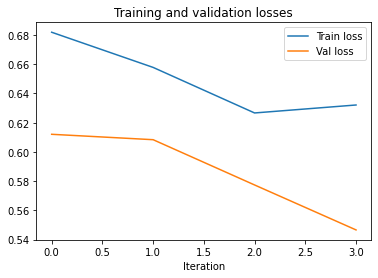

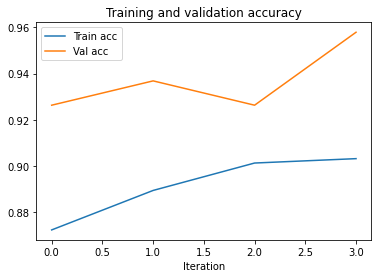

In [ ]:
plt.figure()
plt.title('Training and validation losses')
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(train_acc, label='Train acc')
plt.plot(val_acc, label='Val acc')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), f'./vivit.pth')

In [ ]:
def classification_metrics(y_true, y_pred, binary=True):
    conf_mat = confusion_matrix(y_true, y_pred)

    if binary:
        acc = accuracy_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
    else:
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

    return conf_mat, accuracy, recall, precision, f1

In [ ]:

y_pred = []
y_label = []

model.eval()
with torch.no_grad():
    for batch_id, (data, lr, action, label) in enumerate(tqdm(test_loader)):
        batch_size = data.size(0)
        data, label = data.to(device), label.float().to(device)
        lr, action = lr.to(device), action.to(device)

        outputs = model(data, lr, action)

        y_pred.extend(torch.argmax(outputs, dim=1).cpu().detach().numpy())
        y_label.extend(torch.argmax(label, dim=1).cpu().detach().numpy())

print(classification_metrics(y_label, y_pred, False))

100%|██████████| 286/286 [01:31<00:00,  3.12it/s]

(array([[67,  2,  0,  1,  1,  3],
       [ 2, 78,  2,  3,  5,  2],
       [ 0,  1, 17,  0,  0,  1],
       [ 5,  0,  0, 26,  4,  1],
       [ 1,  0,  0,  1, 29,  0],
       [ 2,  1,  2,  0,  0, 29]]), 0.8601398601398601, 0.8601398601398601, 0.866840829439796, 0.8604862732779044)
